In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
ctc_loss = nn.CTCLoss()

# Reproducibility check
np.random.seed(785)
torch.manual_seed(785)
torch.cuda.manual_seed(785)

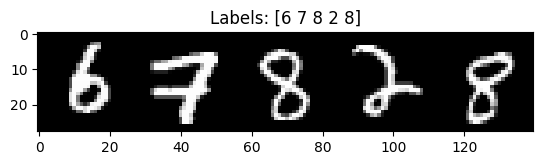

(20000, 28, 140)
(20000, 5)


In [3]:
from tensorflow.keras.datasets import mnist

# Loading MNIST data and creating a handwritten digit sequence 
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def create_sequences(images, labels, num_sequences=20000, sequence_length=5):
    # Initialize arrays to hold sequences and sequence labels
    height, width = images[0].shape
    total_width = width * sequence_length
    all_sequences = np.zeros((num_sequences, height, total_width), dtype=np.uint8)
    all_labels = np.zeros((num_sequences, sequence_length), dtype=int)

    for i in range(num_sequences):
        idx = np.random.choice(len(images), sequence_length)
        sequence_images = images[idx]
        sequence_labels = labels[idx]

        # Creating one sequence
        new_sequence = np.hstack(sequence_images)
        
        # Storing the sequence and the labels
        all_sequences[i] = new_sequence
        all_labels[i] = sequence_labels

    return all_sequences, all_labels

# Generating 20,000 sequence data 
sequences, sequence_labels = create_sequences(train_images, train_labels, 20000, 5)

# Visualization 
plt.imshow(sequences[0], cmap='gray')
plt.title('Labels: {}'.format(sequence_labels[0]))
plt.show()
print(sequences.shape)
print(sequence_labels.shape)

In [4]:
# Defining the CTC model with BLSTM

class CTCModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CTCModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, proj_size=0)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        # Initializing peephole connections and forget gate biases (doesn't help the model that much)
        for layer in range(num_layers):
            for direction in range(2):  
                layer_params = getattr(self.lstm, f'bias_ih_l{layer}')
                if direction == 1:
                    layer_params = getattr(self.lstm, f'bias_ih_l{layer}_reverse')
                
                layer_params.data[hidden_size:2*hidden_size].fill_(1.0)
                peephole_weights = torch.zeros(3 * hidden_size)
                setattr(self.lstm, f'peephole_ih_l{layer}_{direction}', nn.Parameter(peephole_weights))
                setattr(self.lstm, f'peephole_hh_l{layer}_{direction}', nn.Parameter(peephole_weights))

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# Converting sequences and sequence_labels to PyTorch tensors
sequences_tensor = torch.tensor(sequences, dtype=torch.float32).permute(0, 2, 1)
sequence_labels_tensor = torch.tensor(sequence_labels, dtype=torch.long)

# Creating a dataset and data loader
dataset = TensorDataset(sequences_tensor, sequence_labels_tensor)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model parameters
input_size = 28  # Digit sequence dimensions
hidden_size = 128 # Had to change these compared to the paper
num_layers = 2
num_classes = 10  # Number of digits (0-9) + blank label

# Instantiating training the model
model = CTCModel(input_size, hidden_size, num_layers, num_classes + 1)  # +1 for blank label
criterion = nn.CTCLoss(blank=num_classes, reduction='mean', zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
for epoch in range(num_epochs):
    for sequences, labels in dataloader:
        optimizer.zero_grad()

        # Forward pass
        logits = model(sequences)

        input_lengths = torch.full((batch_size,), logits.size(1), dtype=torch.long)
        label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)

        logits = logits.log_softmax(2).permute(1, 0, 2)
        ctc_loss = criterion(logits, labels, input_lengths, label_lengths)

        # Backward pass and optimization
        ctc_loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {ctc_loss.item():.4f}")

print("Training completed.")

/Users/hadikeramati/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/30], Loss: 0.3281
Epoch [2/30], Loss: 0.2079
Epoch [3/30], Loss: 0.1038
Epoch [4/30], Loss: 0.0962
Epoch [5/30], Loss: 0.1127
Epoch [6/30], Loss: 0.0822
Epoch [7/30], Loss: 0.0132
Epoch [8/30], Loss: 0.0163
Epoch [9/30], Loss: 0.0412
Epoch [10/30], Loss: 0.0813
Epoch [11/30], Loss: 0.0213
Epoch [12/30], Loss: 0.0574
Epoch [13/30], Loss: 0.0714
Epoch [14/30], Loss: 0.0112
Epoch [15/30], Loss: 0.0175
Epoch [16/30], Loss: 0.0078
Epoch [17/30], Loss: 0.0024
Epoch [18/30], Loss: 0.0114
Epoch [19/30], Loss: 0.0170


KeyboardInterrupt: 

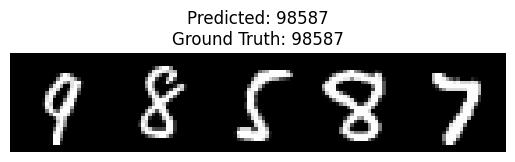

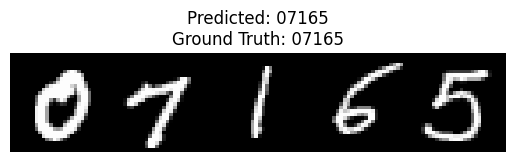

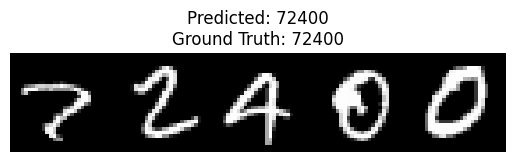

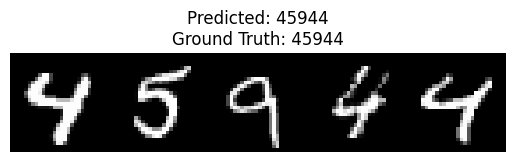

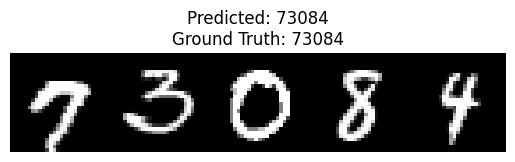

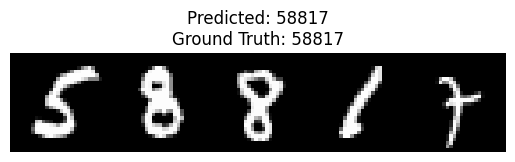

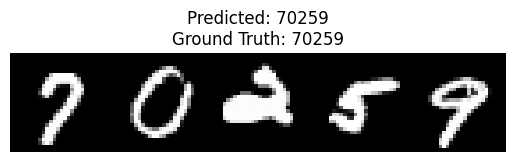

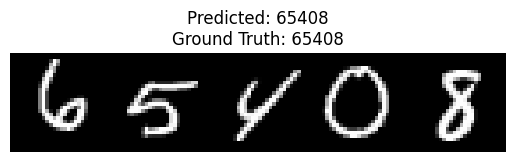

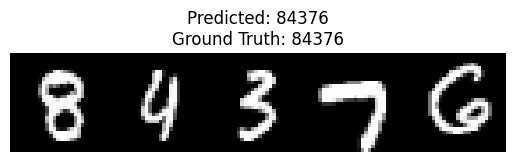

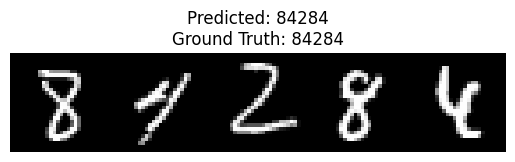

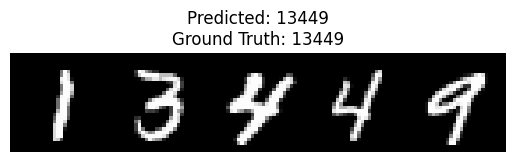

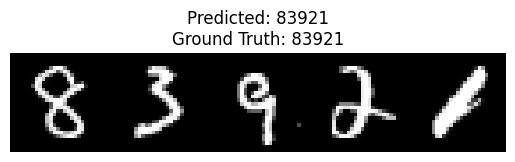

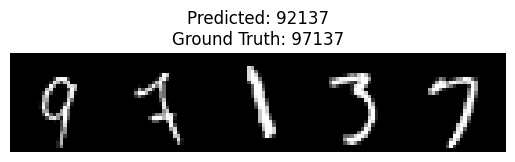

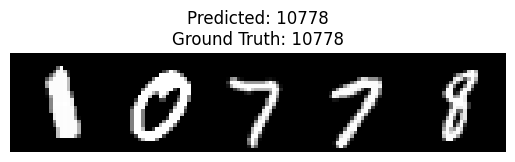

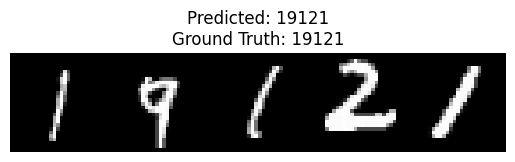

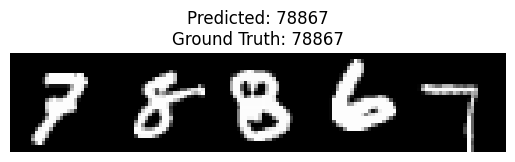

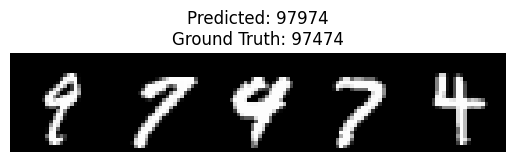

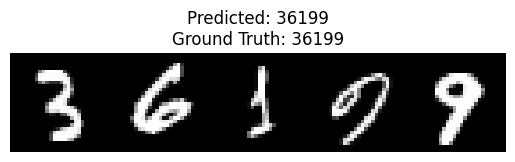

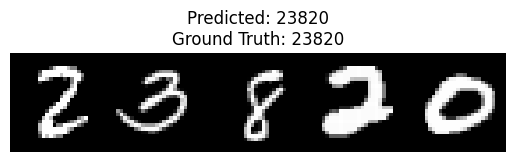

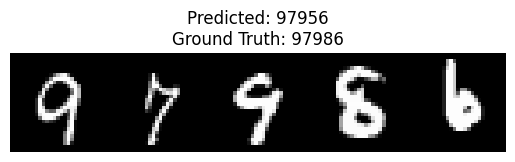

In [5]:
# Generating test data 
test_sequences, test_sequence_labels = create_sequences(test_images, test_labels, num_sequences=20, sequence_length=5)
test_sequences_tensor = torch.tensor(test_sequences, dtype=torch.float32).permute(0, 2, 1)

# Evaluation
model.eval()

for i in range(len(test_sequences)):
    sequence = test_sequences_tensor[i].unsqueeze(0)
    
    # Forward pass
    with torch.no_grad():
        logits = model(sequence)
    
    # Decoding the CTC output
    output = logits.permute(1, 0, 2).log_softmax(2).argmax(2).squeeze(0)
    
    # Converting output to a list of integers
    output_list = output.tolist()
    
    # CTC decoding
    predicted_sequence = []
    previous_digit = -1
    for digit in output_list:
        if digit != previous_digit:
            if digit != [10]:  # blank label index
                predicted_sequence.append(str(digit[0]))
            previous_digit = digit
    
    predicted_sequence = ''.join(predicted_sequence)
    
    # Converting the ground truth label to a string
    ground_truth_sequence = ''.join(str(digit) for digit in test_sequence_labels[i])
    
    # Display the input image
    plt.imshow(test_sequences[i], cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {predicted_sequence}\nGround Truth: {ground_truth_sequence}")
    plt.show()